In [2]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split

In [ ]:
rf = Roboflow(api_key="MpvsUqlZ6XI3YRK7mo3G")
project = rf.workspace("file").project("romato")
dataset = project.version(2).download("yolov9")

In [3]:
# Function to load and preprocess images
def load_data(path):
    images = []
    labels = []

    # Load ripe tomatoes images
    for file in glob.glob(os.path.join(path, 'Images', 'Riped tomato_*.jpeg')):
        img = cv2.imread(file)
        img = cv2.resize(img, (224, 224))
        images.append(img)
        labels.append(1)  # label 1 for ripe tomatoes

    # Load unripe tomatoes images
    for file in glob.glob(os.path.join(path, 'Images', 'unriped tomato_*.jpeg')):
        img = cv2.imread(file)
        img = cv2.resize(img, (224, 224))
        images.append(img)
        labels.append(0)  # label 0 for unripe tomatoes

    # Convert to numpy arrays and normalize images to 0-1 range
    images = np.array(images) / 255.0
    labels = np.array(labels)

    # Split data into training and testing sets
    train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

    return train_data, test_data, train_labels, test_labels

In [4]:
# Function to create the model
def create_model():
    # Load VGG16 model with pre-trained weights, excluding the top (fully connected) layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze the convolutional layers
    for layer in base_model.layers:
        layer.trainable = False
    
    model = keras.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [5]:
# Function to train the model
def train_model(model, train_data, train_labels, test_data, test_labels):
    history = model.fit(train_data, train_labels, epochs=10, validation_data=(test_data, test_labels))
    
    # Save the model
    model.save('cnn_vgg16.pb')
    
    return model, history

# Function to evaluate the model
def evaluate_model(model, test_data, test_labels):
    loss, accuracy = model.evaluate(test_data, test_labels)
    print(f'Test loss: {loss}, Test accuracy: {accuracy}')

# Load data
train_data, test_data, train_labels, test_labels = load_data('dataset')

# Create model
model = create_model()

# Train model
model, history = train_model(model, train_data, train_labels, test_data, test_labels)

# Evaluate model
evaluate_model(model, test_data, test_labels)

Epoch 1/10
7/7 [==============================] - 24s 3s/step - loss: 1.0832 - accuracy: 0.6818 - val_loss: 0.2261 - val_accuracy: 0.9107
Epoch 2/10
7/7 [==============================] - 24s 4s/step - loss: 0.3025 - accuracy: 0.9045 - val_loss: 0.1980 - val_accuracy: 0.9464
Epoch 3/10
7/7 [==============================] - 25s 4s/step - loss: 0.1013 - accuracy: 0.9636 - val_loss: 0.1761 - val_accuracy: 0.9464
Epoch 4/10
7/7 [==============================] - 25s 4s/step - loss: 0.0755 - accuracy: 0.9773 - val_loss: 0.2716 - val_accuracy: 0.9464
Epoch 5/10
7/7 [==============================] - 25s 4s/step - loss: 0.0385 - accuracy: 0.9864 - val_loss: 0.1978 - val_accuracy: 0.9464
Epoch 6/10
7/7 [==============================] - 25s 4s/step - loss: 0.0182 - accuracy: 0.9955 - val_loss: 0.1900 - val_accuracy: 0.9643
Epoch 7/10
7/7 [==============================] - 25s 4s/step - loss: 0.0202 - accuracy: 0.9955 - val_loss: 0.2667 - val_accuracy: 0.9464
Epoch 8/10
7/7 [==================

INFO:tensorflow:Assets written to: cnn_vgg16.pb\assets


2/2 [==============================] - 5s 2s/step - loss: 0.3126 - accuracy: 0.9464
Test loss: 0.3126041889190674, Test accuracy: 0.9464285969734192


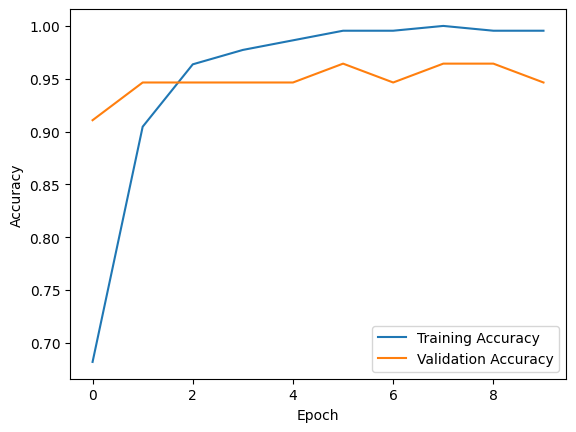

In [6]:
# Plot training accuracy and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()